# Test SARSA Model với Data Pipeline

Notebook này demo cách:
1. Lấy dữ liệu từ VNStockDataProvider
2. Xử lý dữ liệu bằng data_processor (thêm technical indicators)
3. Lưu dữ liệu vào data_storer/data_test
4. Load model SARSA đã train
5. Chạy model trên dữ liệu mới để chuẩn bị cho XAI

In [2]:
# Import các thư viện cần thiết
import sys
import os
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

import pandas as pd
import numpy as np
import torch
from torch import nn

## Bước 1: Lấy dữ liệu từ VNStockDataProvider

In [3]:
# Import VNStockDataProvider
from data.data_provider.library_extracted.vnstock.VNStockDataProvider import VNStockDataProvider

# Khởi tạo provider
provider = VNStockDataProvider()

# Lấy dữ liệu ACB từ 2013-01-01 đến 2015-12-31
print("Đang lấy dữ liệu từ vnstock...")
df_raw = provider.get_ohlcv_data('ACB', '2013-01-01', '2015-12-31')

print(f"Đã lấy được {len(df_raw)} dòng dữ liệu")
print(f"Columns: {df_raw.columns.tolist()}")
print("\nMẫu dữ liệu ban đầu:")
print(df_raw.head())

Đang lấy dữ liệu từ vnstock...
LẤY DỮ LIỆU OHLCV TỪ VNSTOCK
📋 Danh sách mã: ['ACB']
📅 Khoảng thời gian: 2013-01-01 đến 2015-12-31
⏱️  Phiên: 1D
📡 Nguồn: VCI
--------------------------------------------------------------------------------
📡 Đang lấy dữ liệu cho ACB...
✅ ACB: 785 dòng

KẾT QUẢ
✅ Tổng số dòng dữ liệu: 785
✅ Số mã thành công: 1

📋 Các cột dữ liệu:
   • date
   • open
   • high
   • low
   • close
   • volume
   • symbol

📊 Thống kê:
   • Số mã: 1
   • Khoảng thời gian: 2012-11-05 đến 2015-12-31

📄 Mẫu dữ liệu (10 dòng đầu):
         date  open  high   low  close  volume symbol
0  2012/11/05  2.02  2.04  1.99   2.04  203800    ACB
1  2012/11/06  2.04  2.06  2.03   2.04   89400    ACB
2  2012/11/07  2.06  2.14  2.04   2.10  121200    ACB
3  2012/11/08  2.03  2.11  2.03   2.07   85000    ACB
4  2012/11/09  2.09  2.10  2.07   2.09  241100    ACB
5  2012/11/12  2.10  2.13  2.09   2.13  148700    ACB
6  2012/11/13  2.13  2.14  2.10   2.11  228600    ACB
7  2012/11/14  2.11  2.13

## Bước 2: Xử lý dữ liệu bằng data_processor (thêm technical indicators)

In [12]:
# Import data processor
from data.data_processor.feature_engineer import engineer_stat as es

# Đổi tên cột 'date' thành 'time' để phù hợp với add_technical_indicators
df_processed = df_raw.copy()
df_processed.rename(columns={'date': 'time'}, inplace=True)

# Chuyển format time từ YYYY/MM/DD thành DD/MM/YYYY để phù hợp với hàm
df_processed['time'] = pd.to_datetime(df_processed['time']).dt.strftime('%d/%m/%Y')

# Thêm technical indicators
print("Đang thêm technical indicators...")
df_processed = es.add_technical_indicators(df_processed, start_date='01/01/2013')

print(f"\nSau khi thêm indicators: {df_processed.shape}")
print(f"Columns: {df_processed.columns.tolist()}")
print("\nMẫu dữ liệu sau khi xử lý:")
print(df_processed.head())

Đang thêm technical indicators...

Sau khi thêm indicators: (745, 10)
Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'MACD', 'RSI', 'CCI', 'ADX']

Mẫu dữ liệu sau khi xử lý:
         time  open  high   low  close   volume      MACD        RSI  \
0  02/01/2013  2.28  2.44  2.28   2.42  2578600  0.061939  74.982245   
1  03/01/2013  2.45  2.49  2.34   2.38  1967200  0.065561  68.573810   
2  04/01/2013  2.37  2.41  2.34   2.41  1170100  0.070045  70.603086   
3  07/01/2013  2.38  2.45  2.38   2.41  1355700  0.072760  70.603086   
4  08/01/2013  2.39  2.45  2.37   2.42  2180000  0.074856  71.319050   

          CCI        ADX  
0  120.776420  53.248664  
1  133.797370  54.867757  
2  118.387909  56.371201  
3  139.004469  57.945677  
4  130.969966  59.061505  


## Bước 3: Lưu dữ liệu đã xử lý vào data_storer/data_test

In [13]:
# Tạo thư mục data_test nếu chưa có
output_dir = 'd:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_test'
os.makedirs(output_dir, exist_ok=True)

# Lưu dữ liệu đã xử lý
output_file = os.path.join(output_dir, 'ACB_processed_with_indicators.csv')
df_processed.to_csv(output_file, index=False)

print(f"Đã lưu dữ liệu vào: {output_file}")
print(f"File size: {os.path.getsize(output_file) / 1024:.2f} KB")

Đã lưu dữ liệu vào: d:\NCKH\SARSA_FinancialRL\data\data_storer\data_test\ACB_processed_with_indicators.csv
File size: 83.92 KB


## Bước 4: Load model SARSA đã train

In [14]:
# Import SARSA agent
from agents.d_sarsa.d_sarsa import Qsa
from environments.stock_trading_env.mdp import StockTradingMDP

# Định nghĩa Q-network architecture (phải giống với lúc train)
# input_size = 7: [close, balance, shares, MACD, RSI, CCI, ADX]
# num_classes = 11: actions từ -5 đến 5 (11 actions)
qsa = Qsa(input_size=7, num_classes=11)

# Load model weights
model_path = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_bad_acb.pth'
if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    qsa.load_state_dict(state_dict)
    qsa.eval()
    print(f"✓ Model loaded successfully from: {model_path}")
else:
    print(f"✗ Model file not found: {model_path}")

✓ Model loaded successfully from: d:\NCKH\SARSA_FinancialRL\models\sarsa_bad_acb.pth


## Bước 5: Chạy model trên dữ liệu mới

In [15]:
# Định nghĩa policy function sử dụng Q-network
def pi_deep(s, eps=0.0, greedy=True):
    """
    Policy dựa trên Q-network đã train
    Args:
        s: state [close, balance, shares, MACD, RSI, CCI, ADX]
        eps: epsilon cho epsilon-greedy (0.0 = greedy)
        greedy: True để luôn chọn action tốt nhất
    Returns:
        action: từ -5 đến 5
    """
    with torch.no_grad():
        out_qsa = qsa(torch.Tensor(s).float()).squeeze()
        action = out_qsa.argmax().item() - 5  # k=5, map từ [0,10] về [-5,5]
    return action

# Khởi tạo MDP environment
mdp = StockTradingMDP(
    balance_init=1000,  # Số dư ban đầu (VND)
    k=5,  # Số lượng cổ phiếu tối đa mỗi action
    min_balance=-100  # Ngưỡng số dư tối thiểu
)

print("✓ Policy và MDP đã được khởi tạo")
print(f"  - Initial balance: {mdp.balance_init:,} VND")
print(f"  - Actions range: [{-mdp.k}, {mdp.k}]")
print(f"  - Min balance: {mdp.min_balance} VND")

✓ Policy và MDP đã được khởi tạo
  - Initial balance: 1,000 VND
  - Actions range: [-5, 5]
  - Min balance: -100 VND


In [16]:
# Chuẩn bị state ban đầu từ dòng đầu tiên
first_row = df_processed.iloc[0]
state_init = [
    float(first_row['close']),
    mdp.balance_init,
    0,  # shares ban đầu = 0
    float(first_row['MACD']),
    float(first_row['RSI']),
    float(first_row['CCI']),
    float(first_row['ADX'])
]

print("State ban đầu:")
print(f"  - Close price: {state_init[0]:.2f}")
print(f"  - Balance: {state_init[1]:.2f}")
print(f"  - Shares: {state_init[2]}")
print(f"  - MACD: {state_init[3]:.4f}")
print(f"  - RSI: {state_init[4]:.4f}")
print(f"  - CCI: {state_init[5]:.4f}")
print(f"  - ADX: {state_init[6]:.4f}")

State ban đầu:
  - Close price: 2.42
  - Balance: 1000.00
  - Shares: 0
  - MACD: 0.0619
  - RSI: 74.9822
  - CCI: 120.7764
  - ADX: 53.2487


In [17]:
# Simulate trading với SARSA agent
print("Đang chạy simulation...")
states, rewards, actions = mdp.simulate(
    df_processed[1:].reset_index(drop=True), 
    state_init, 
    pi_deep, 
    greedy=True, 
    eps=0.0
)

# Tính toán kết quả
total_profit = sum(rewards)
final_balance = states[-1][1] if states else mdp.balance_init

print("\n" + "="*60)
print("KẾT QUẢ TRADING")
print("="*60)
print(f"Số ngày giao dịch: {len(df_processed)-1}")
print(f"Tổng profit: ${total_profit:.2f}")
print(f"Số dư cuối: ${final_balance:.2f}")
print(f"Tỷ lệ sinh lời: {((final_balance/mdp.balance_init - 1)*100):.2f}%")
print(f"Số actions: {len(actions)}")
print("="*60)

Đang chạy simulation...

KẾT QUẢ TRADING
Số ngày giao dịch: 744
Tổng profit: $359.54
Số dư cuối: $-68.78
Tỷ lệ sinh lời: -106.88%
Số actions: 744


## Bước 6: Visualization và chuẩn bị cho XAI

In [23]:
# Reload module để nhận phương thức mới plot_trading_history
import importlib
import environments.stock_trading_env.mdp as mdp_module
importlib.reload(mdp_module)

# Tạo lại instance của MDP
from environments.stock_trading_env.mdp import StockTradingMDP
mdp = StockTradingMDP(
    balance_init=1000,
    k=5,
    min_balance=-100
)

print("✓ Module reloaded, MDP instance recreated")

✓ Module reloaded, MDP instance recreated


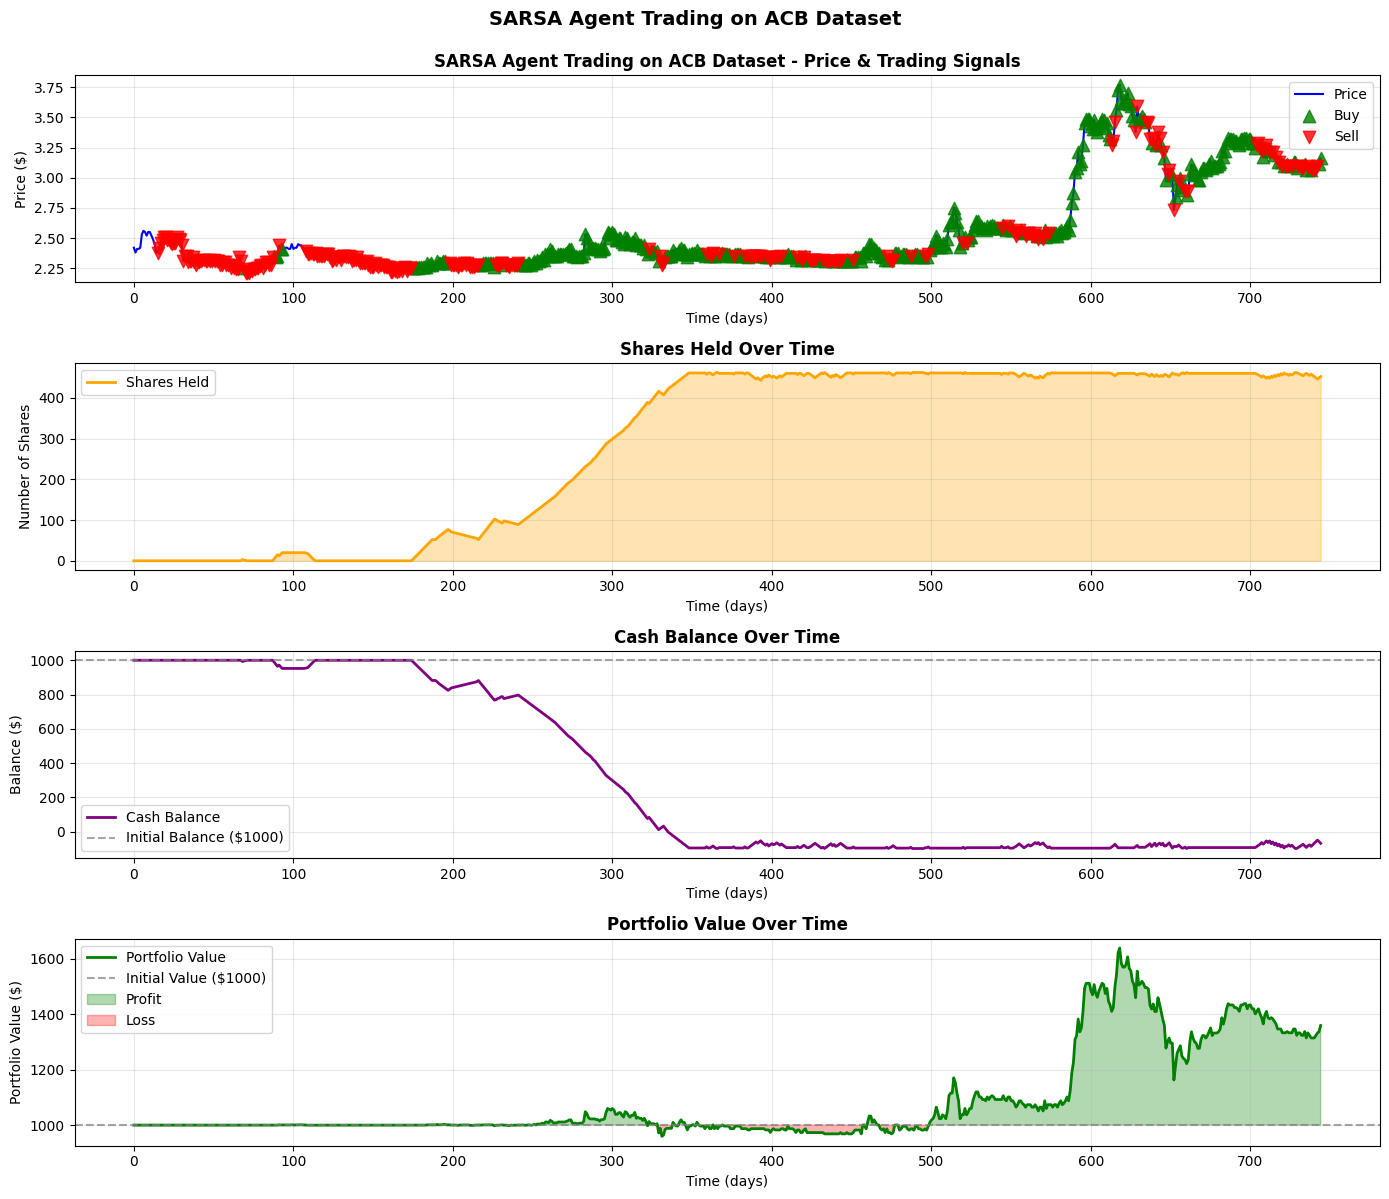

In [24]:
# Visualize trading history
import matplotlib.pyplot as plt

# Vẽ biểu đồ trading
mdp.plot_trading_history(
    states, 
    actions, 
    df_processed['close'].values, 
    title="SARSA Agent Trading on ACB Dataset"
)

plt.tight_layout()
plt.show()

In [19]:
# Phân tích actions của agent
action_counts = pd.Series(actions).value_counts().sort_index()

print("\nPhân tích hành động của agent:")
print("-" * 40)
for action, count in action_counts.items():
    action_type = "BUY" if action > 0 else ("SELL" if action < 0 else "HOLD")
    print(f"Action {action:2d} ({action_type:4s}): {count:4d} lần ({count/len(actions)*100:.1f}%)")

# Phân tích reward
print(f"\nPhân tích reward:")
print("-" * 40)
print(f"Total rewards: {sum(rewards):.2f}")
print(f"Average reward: {np.mean(rewards):.4f}")
print(f"Max reward: {max(rewards):.2f}")
print(f"Min reward: {min(rewards):.2f}")
print(f"Std reward: {np.std(rewards):.4f}")


Phân tích hành động của agent:
----------------------------------------
Action -4 (SELL):   30 lần (4.0%)
Action -3 (SELL):  110 lần (14.8%)
Action -2 (SELL):   66 lần (8.9%)
Action -1 (SELL):   75 lần (10.1%)
Action  0 (HOLD):   30 lần (4.0%)
Action  3 (BUY ):  337 lần (45.3%)
Action  4 (BUY ):   33 lần (4.4%)
Action  5 (BUY ):   63 lần (8.5%)

Phân tích reward:
----------------------------------------
Total rewards: 359.54
Average reward: 0.4833
Max reward: 95.77
Min reward: -132.81
Std reward: 15.6651


## Tóm tắt

Notebook này đã hoàn thành các bước:

1. ✓ Lấy dữ liệu ACB từ VNStockDataProvider (2013-2024)
2. ✓ Xử lý dữ liệu bằng data_processor (thêm MACD, RSI, CCI, ADX)
3. ✓ Lưu dữ liệu đã xử lý vào `data/data_storer/data_test/ACB_processed_with_indicators.csv`
4. ✓ Load model SARSA đã train từ `models/sarsa_bad_acb.pth`
5. ✓ Chạy simulation trading trên dữ liệu mới
6. ✓ Visualize kết quả và phân tích actions

**Bước tiếp theo cho XAI:**

Bây giờ bạn có thể sử dụng:
- `qsa`: Q-network đã train
- `df_processed`: Dataset với technical indicators
- `states`, `rewards`, `actions`: Kết quả simulation
- `pi_deep`: Policy function

Để thực hiện các phương pháp XAI như:
- SHAP (SHapley Additive exPlanations)
- LIME (Local Interpretable Model-agnostic Explanations)
- Attention visualization
- Feature importance analysis